In [1]:
# Core Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# LSTM Modeling
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
import tensorflow as tf

# Setup
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 7)
FIGURES_PATH = '../reports/figures/'
os.makedirs(FIGURES_PATH, exist_ok=True)



In [2]:
# Load Data and Model
try:
    close_prices = pd.read_csv('../data/processed/close_prices.csv', index_col='Date', parse_dates=True)
    tsla_data = close_prices['TSLA'].asfreq('B').fillna(method='ffill')
    
    # Load the LSTM model
    lstm_model = load_model('../models/lstm_model.h5')
    
    print("Data and LSTM model loaded successfully.")
except FileNotFoundError as e:
    print(f"Error: {e}. Please ensure the required files from previous tasks exist.")
    exit()

C:\Users\Yoga i7\AppData\Local\Temp\ipykernel_2116\3181287324.py:4: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  tsla_data = close_prices['TSLA'].asfreq('B').fillna(method='ffill')


Data and LSTM model loaded successfully.


In [4]:
# Re-create the Scaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_full_data = scaler.fit_transform(tsla_data.values.reshape(-1, 1))

# Save the scaler for the next task
os.makedirs('../models/', exist_ok=True) 
joblib.dump(scaler, '../models/scaler.pkl')
print("Scaler object saved for future use.")

Scaler object saved for future use.


In [6]:
# Multi-Step Forecasting with MC Dropout

# A wrapper model to run with dropout active during prediction
def get_mc_model(model):
    in_ = tf.keras.layers.Input(shape=model.input_shape[1:])
    x = in_
    for layer in model.layers:
        if isinstance(layer, tf.keras.layers.Dropout):
            x = layer(x, training=True)
        else:
            x = layer(x)
    return tf.keras.Model(in_, x)

mc_lstm_model = get_mc_model(lstm_model)

def generate_future_forecast_mc(model, initial_input_data, n_future_steps, n_simulations):
    """Generates future forecasts using MC Dropout."""
    all_simulations = []
    
    for i in range(n_simulations):
        if (i + 1) % 10 == 0:
            print(f"Running simulation {i+1}/{n_simulations}...")
            
        current_input = initial_input_data.copy()
        simulation_forecast = []
        
        for _ in range(n_future_steps):
            pred = model.predict(current_input, verbose=0)
            simulation_forecast.append(pred[0, 0])
            new_input_step = pred.reshape(1, 1, 1)
            current_input = np.append(current_input[:, 1:, :], new_input_step, axis=1)
        
        all_simulations.append(simulation_forecast)
        
    return np.array(all_simulations)



In [7]:
# Generate the Forecast
TIME_STEP = 60
FORECAST_HORIZON = 252 
N_SIMULATIONS = 100 
last_60_days_scaled = scaled_full_data[-TIME_STEP:]
initial_input = last_60_days_scaled.reshape(1, TIME_STEP, 1)

print(f"Generating {FORECAST_HORIZON}-day forecast with {N_SIMULATIONS} MC simulations...")
future_forecasts_scaled = generate_future_forecast_mc(mc_lstm_model, initial_input, FORECAST_HORIZON, N_SIMULATIONS)

# Process Forecast Results
future_forecasts = scaler.inverse_transform(future_forecasts_scaled.T).T
mean_forecast = future_forecasts.mean(axis=0)
lower_bound = np.percentile(future_forecasts, 2.5, axis=0)
upper_bound = np.percentile(future_forecasts, 97.5, axis=0)
print("Forecast generation complete.")

Generating 252-day forecast with 100 MC simulations...
Running simulation 10/100...
Running simulation 20/100...
Running simulation 30/100...
Running simulation 40/100...
Running simulation 50/100...
Running simulation 60/100...
Running simulation 70/100...
Running simulation 80/100...
Running simulation 90/100...
Running simulation 100/100...
Forecast generation complete.



Forecast plot saved to: ../reports/figures/04_lstm_future_forecast.png


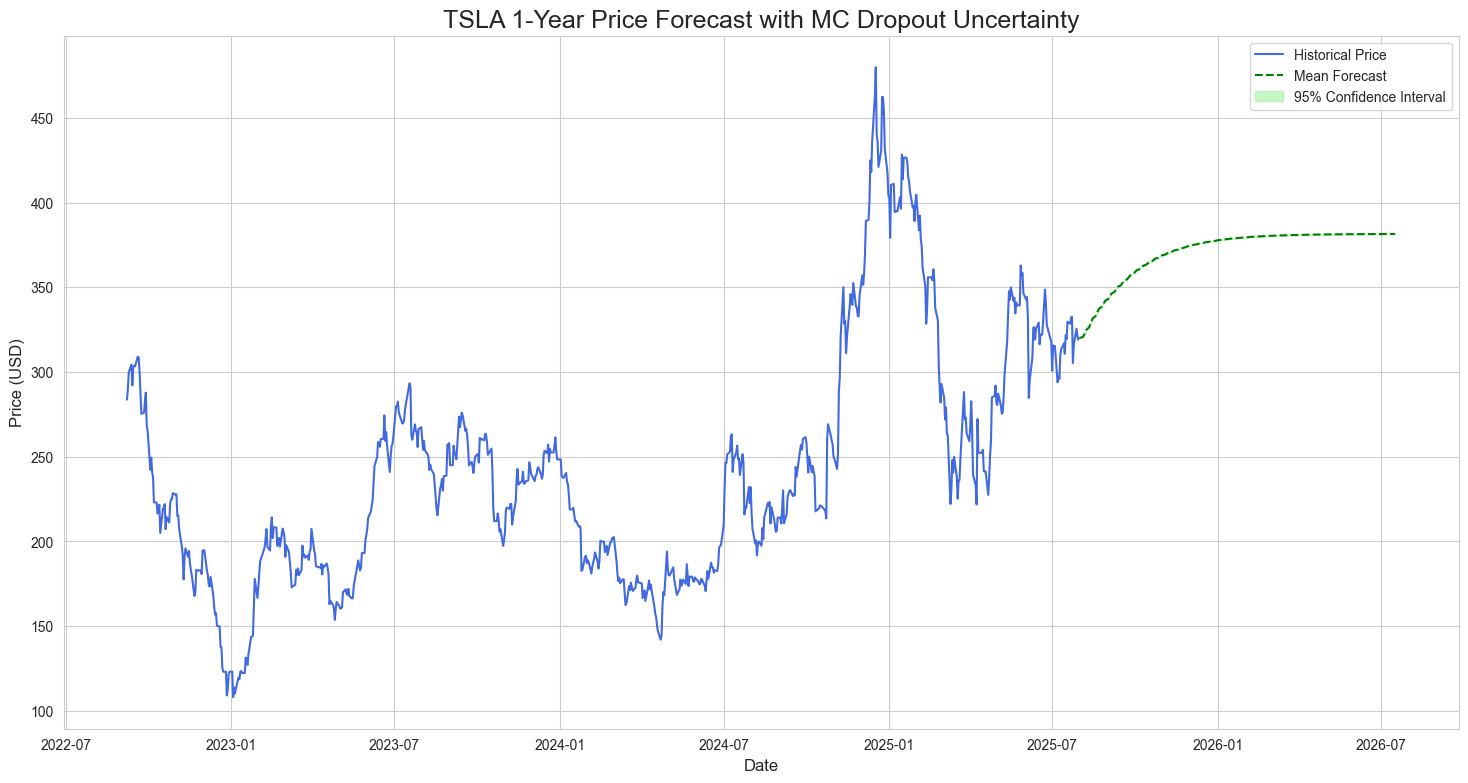

In [8]:
# Visualize the Forecast with Confidence Intervals

# Create a future date range for the x-axis
last_date = tsla_data.index[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(days=1), periods=FORECAST_HORIZON, freq='B')

# Plot
plt.figure(figsize=(18, 9))
plt.plot(tsla_data.index[-756:], tsla_data.values[-756:], label='Historical Price', color='royalblue')
plt.plot(future_dates, mean_forecast, label='Mean Forecast', color='green', linestyle='--')
plt.fill_between(future_dates, lower_bound, upper_bound, color='lightgreen', alpha=0.5, label='95% Confidence Interval')

plt.title('TSLA 1-Year Price Forecast with MC Dropout Uncertainty', fontsize=18)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (USD)', fontsize=12)
plt.legend()
plt.grid(True)

file_path = os.path.join(FIGURES_PATH, '04_lstm_future_forecast.png')

plt.savefig(file_path, dpi=300, bbox_inches='tight')
print(f"\nForecast plot saved to: {file_path}")

plt.show()

In [9]:
np.save('../models/lstm_mean_forecast.npy', mean_forecast)